## 1. Biblioteca

In [140]:
# Gerais
import yfinance as yf
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Gráficos de Autoorrelação
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Modelo ARIMA
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Análise de Resíduos
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

# Estatísticas de Erro
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

## 1. Introdução

O Ibovespa é o princípal índice de ações do Brasil, ele fruto de uma carteira teórica que reúne as companhias mais importantes do país e que representa mais de 80% do valor negociado na bolsa. O objetivo deste estudo é estimar um modelo para previsão do Ibovespa usando ARIMA (Autoregressive Integrated Moving Average) que é um método para modelagem de séries temporais desenvolvida pelos estatísticos George Box e Gwilym Jenkins na década de 70, este modelo pressupõe que o comportamento de uma série temporal integrada pode ser explicada pelos seus próprios valores e resíduos defasados. 

## 2. Extração e Análise Exploratória da Base de Dados

Foi extraído da base de dados do Yahoo Finance por meio da biblioteca yfinance a cotação de fechamento do índice Ibovespa (^BVSP) dos últimos 15 anos. 

<Axes: xlabel='Date'>

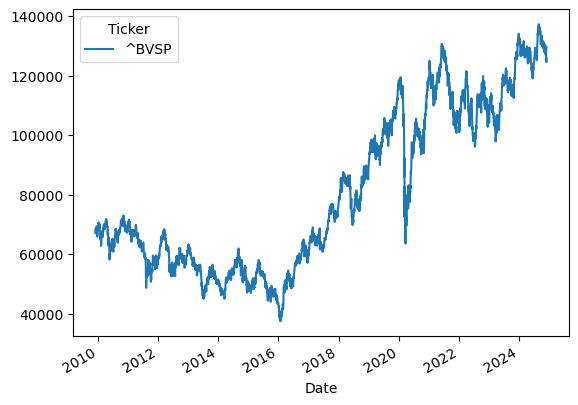

In [143]:
ibov = pd.DataFrame()

ibov = yf.download('^BVSP', start = '2009-11-30', end = '2024-11-30', progress=False, interval="1d")['Adj Close']

ibov.plot()

Os dados diários apresentam muito ruído, isto me levou a optar pelos dados mensais que aparentemente capturam melhor o movimento dos preços. Também normalizamos pelo logarítmo natural que torna os dados mais simétricos e suaviza a magnitude das variações nos preços. 

<Axes: xlabel='Date'>

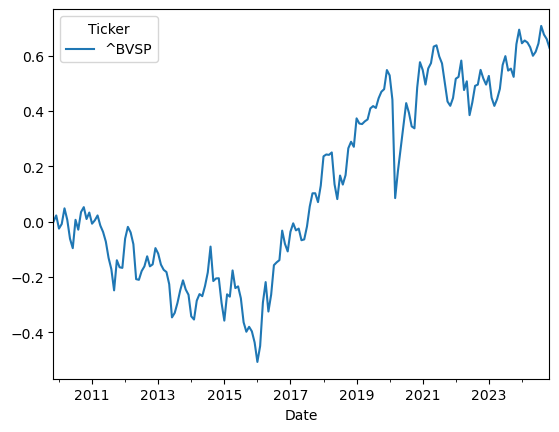

In [146]:
ibov_data = ibov.resample('ME').last()
ibov_data = np.log(ibov_data/ibov_data.iloc[0])

ibov_data.plot()

Calculamos a primeira diferença dos retornos, o que chama atenção é a presença de um outlier referente aos anos de 2008 e 2020 onde o Ibovespa teve uma forte queda, isto é de especial importância visto que a hipótese de retornos normalmente distribuídos pode acabar sendo violada. 

<Axes: ylabel='Count'>

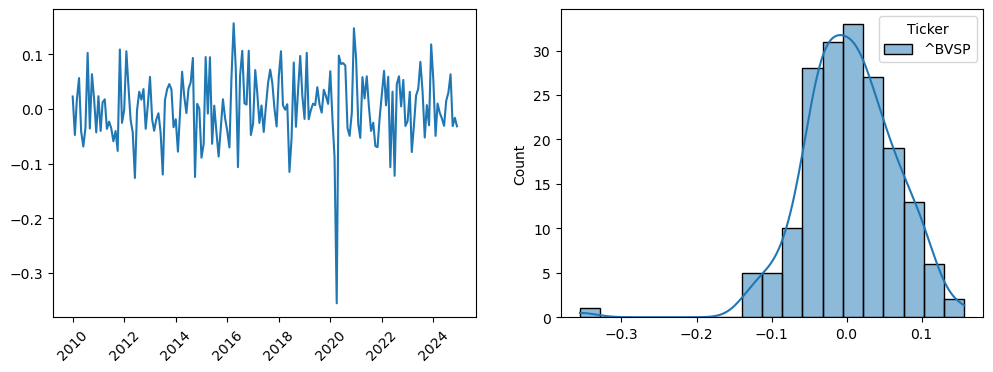

In [149]:
ibov_diff = ibov_data.diff().dropna()

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1) 
plt.plot(ibov_diff)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2) 
sns.histplot(ibov_diff, kde=True)

## Estacionariedade

Uma hipótese importante ao modelar séries temporais é verificar se elas são estacionárias, isto é, possuem a média e variância constante ao longo da série. Esta é uma hipótese importante pois caso seja violado geraria estimadores viesados. 

### Teste de Dickey-Fuller Aumentado

Assumindo um nível de significância ($\alpha$ = 5%) estabelece-se a hipótese nula da presença de uma raiz unitária (quando $\phi_1$ = 1), rejeita-se a hipótese nula se o p-valor for menor do que o nível de significância estabelecido. 

In [151]:
result_data = adfuller(ibov_data)
print(f"Estatística: {result_data[0]}")
print(f"p-valor: {result_data[1]}")
if result_data[1] > 0.05:
    print("Não é estacionária")
else:
    print("É estacionária")

Estatística: -0.2375157973684706
p-valor: 0.933899580337305
Não é estacionária


In [152]:
result_diff = adfuller(ibov_diff)
print(f"Estatística: {result_diff[0]}")
print(f"p-valor: {result_diff[1]}")
if result_diff[1] > 0.05:
    print("Não é estacionária")
else:
    print("É estacionária")

Estatística: -8.596511026767871
p-valor: 7.053803717598292e-14
É estacionária


## Função de Autocorrelação

- **Função de Autocorrelação (ACF)**: Mede a correlação de uma série temporal e seus próprios valores em diferentes defasagens (lags).

- **Função de Autocorrelação Parcial (PACF)**: Mede a correlação entre a série temporal e seus valores defasados, eliminando a influência de valores defasados intermediários.

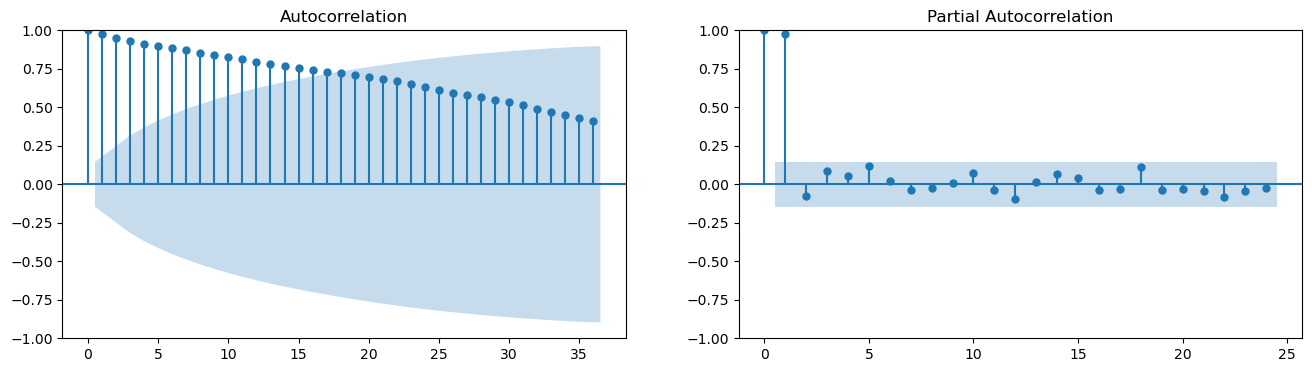

In [155]:
fig, axes = plt.subplots(1, 2, figsize=(16,4))

plot_acf(ibov_data, lags=36, ax=axes[0])
plot_pacf(ibov_data, lags=24, ax=axes[1], method='ywm')

plt.show()

È possível observar que a única defasagem no limiar da significância estatística é o lag 1. 

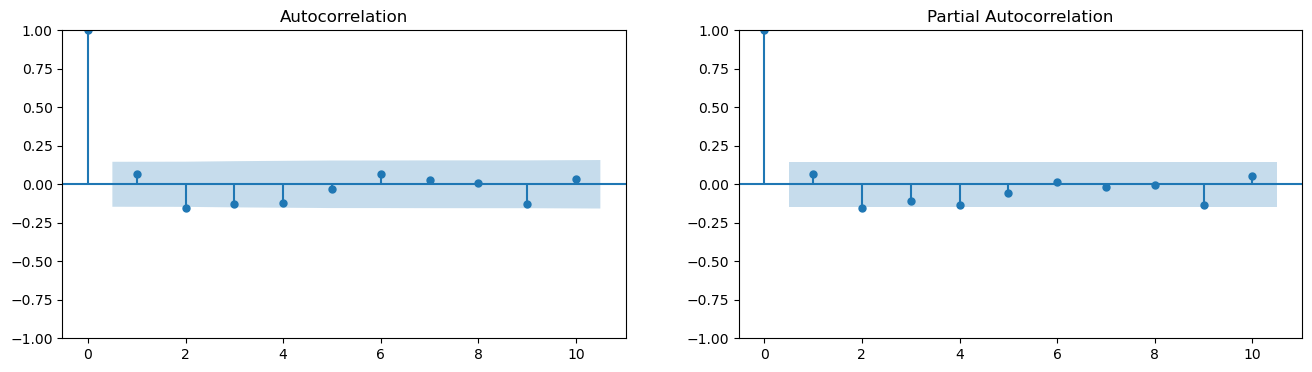

In [159]:
fig, axes = plt.subplots(1, 2, figsize=(16,4))

plot_acf(ibov_diff, lags=10, ax=axes[0])
plot_pacf(ibov_diff, lags=10, ax=axes[1])

plt.show()

### Estatísticas de Erro

- ME: Erro médio, indica a direção e a magnitude média dos erros, podendo ser positivo ou negativo.
- MAE: Média dos erros absolutos, mede a precisão geral ignorando o sinal dos erros.
- RMSE: Raiz da média dos erros quadráticos, dá mais peso a erros maiores e destaca desvios significativos.
- MPE: Erro percentual médio, calcula a média dos erros relativos, considerando sua direção (positivo ou negativo).
- MAPE: Erro percentual médio absoluto, mede a precisão em termos percentuais, ignorando o sinal dos erros.

In [161]:
# Função para gerar as estatísticas de erro
def acuracia(previstos, observados):
    
    teste_values = observados
    previstos_values = previstos
    
    erro = teste_values - previstos_values
    
    # Calculo do Erro Medio
    merror = sum(erro)/len(erro)
    
    # Calculo do Erro Absoluto Medio
    mae = mean_absolute_error(teste_values, previstos_values)

    # Calculo da Raiz Quadrada do Erro Medio
    rmse = root_mean_squared_error(teste_values, previstos_values)

    # Calculo do Erro Percentual Medio
    erro_percentual = (teste_values - previstos_values)/teste_values
    mpe = me = sum(erro_percentual)/len(erro)

    # Calculo do Erro Absoluto Percentual Medio
    mape = mean_absolute_percentage_error(teste_values, previstos_values)
    
    df_erros = pd.DataFrame({
        "Métrica": ["ME", "MAE", "RMSE", "MPE", "MAPE"],
        "Descrição": [
        "Mean Error",
        "Mean Absolute Error",
        "Root Mean Square Error",
        "Mean Percentage Error",
        "Mean Absolute Percentage Error"],
        "Valor": [merror, mae, rmse, mpe, mape]
    })
    
    return df_erros

## 4. ARIMA

Os modelos ARIMA (Modelo Auto-Regressivo Integrado de Médias Móveis) são modelos de séries temporais que possuem três componentes (p, d, q): 

- AR (Auto-Regressivo) = O valor de $y_t$ dependente dos seus valores passados (p)
- I (Integração) = O componente de integração serve para garantir a estacionariedade da série (d)
- MA (Média-Móvel) = O valor de $y_t$ depende da média móvel dos erros passados (q)

Pode ser expresso matematicamente como: 

$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \cdots + \theta_q \varepsilon_{t-q}
$$

Onde: 

- $y_t$: Valor da série temporal no tempo $t$.
- $c$: Constante do modelo.
- $\phi_i$: Coeficientes autorregressivos que capturam a dependência de $y_t$ com seus valores passados ($y_{t-1}, y_{t-2}, \ldots, y_{t-p}$).
- $p$: Ordem do componente autorregressivo (AR).
- $\varepsilon_t$: Resíduo ou erro no tempo $t$.
- $\theta_j$: Coeficientes de médias móveis que capturam a dependência de $\varepsilon_t$ com erros passados ($\varepsilon_{t-1}, \varepsilon_{t-2}, \ldots, \varepsilon_{t-q}$).
- $q$: Ordem do componente de médias móveis (MA).

### O que é AIC? 

O AIC (Critério de Informação de Akaike) é uma métrica usada para comparar modelos estatísticos. Ele avalia a qualidade do ajuste do modelo aos dados ajustando pelo número de parâmetros e a informação perdida. 

### Ajuste por Stepwise

Algorítmo que testa diferentes parâmetros (p, q) e encontra aquele que fornece o menor AIC. 

In [164]:
arima_stepwise = auto_arima(ibov_data,
                            trace = True,
                            stepwise=True)

arima_stepwise.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-488.156, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-485.554, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-484.305, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-484.609, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-486.986, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-489.543, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-487.245, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-483.797, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-487.749, Time=0.47 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-488.328, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-490.033, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-486.767, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-488.105, Time=0.39 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-486.908, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  181
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 249.265
Date:                Sun, 15 Dec 2024   AIC                           -490.531
Time:                        16:56:03   BIC                           -477.759
Sample:                    11-30-2009   HQIC                          -485.352
                         - 11-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7175      0.200      3.583      0.000       0.325       1.110
ar.L2         -0.2065      0.092     -2.238      0.025      -0.387      -0.026
ma.L1         -0.6711      0.212     -3.171      0.002      -1.086      -0.256
sigma2         0.0037      0.000     14.802      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               219.44
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                            -0.98
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Ajuste Manual

Conforme vizualizado, a série se torna estacionária na primeira diferença (d = 1). O maior desafio é definir os parâmetros p e q que segundo os gráficos ACF e PACF havia indicação que o lag 1 era estatisticamente significativo para ambos, o que nos levaria a ajustar um modelo ARIMA (1,1,1), entretanto gerou coeficientes sem significância estatísticas (p-valor > 0.05) que levou a optar pelo modelo ARIMA (0,1,1) que foi o mesmo gerado pelo processo de stepwise, fornece o menor AIC e coeficientes significativos. 

Biblioteca: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

In [168]:
modelo_arima = ARIMA(ibov_data, 
                     order = (2, 1, 1), 
                    ).fit(method_kwargs={'maxiter':1000})

modelo_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  ^BVSP   No. Observations:                  181
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 249.265
Date:                Sun, 15 Dec 2024   AIC                           -490.531
Time:                        16:56:03   BIC                           -477.759
Sample:                    11-30-2009   HQIC                          -485.352
                         - 11-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7175      0.200      3.583      0.000       0.325       1.110
ar.L2         -0.2065      0.092     -2.238      0.025      -0.387      -0.026
ma.L1         -0.6711      0.212     -3.171      0.002      -1.086      -0.256
sigma2         0.0037      0.000     14.802      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               219.44
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                            -0.98
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [169]:
# Parâmetros do modelo
modelo_arima.params

ar.L1     0.717545
ar.L2    -0.206486
ma.L1    -0.671096
sigma2    0.003667
dtype: float64

## 5. Análise de Resíduos

O objetivo final de uma modelagem de uma série temporal é extrair o máximo de estrutura possível de um modelo e o que sobrar, isto é, os resíduos, sejam um ruído branco (média zero, variância constante e sem autocorrelação entre os resíduos). 

Podemos vizualizar graficamente que os resíduos não possuem correlação estatisticamente significativa entre si, isto é também confirmado pelo teste Ljung-Box. 

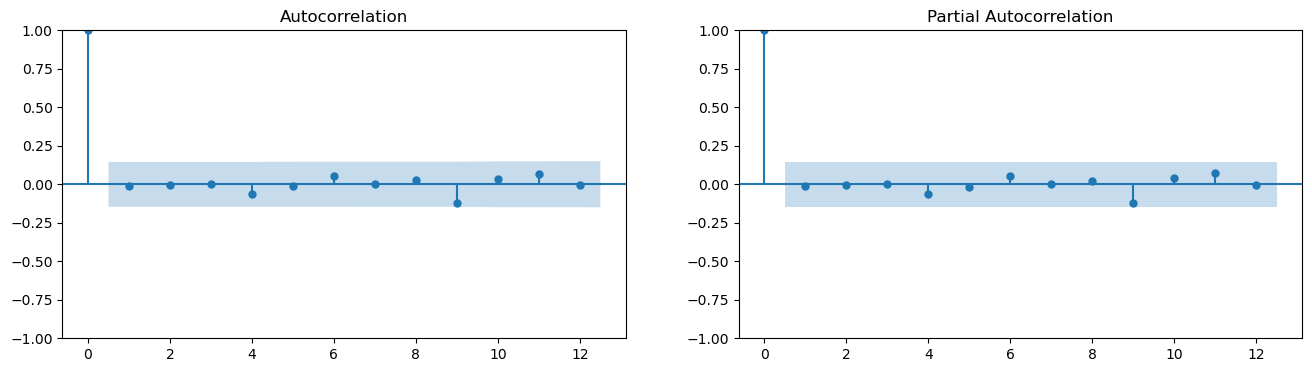

In [171]:
arima_resid = modelo_arima.resid

fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(arima_resid, lags=12, ax=axes[0])
plot_pacf(arima_resid, lags=12, ax=axes[1], method='ywm')
plt.show()

### Teste Ljung–Box

Teste utilizado para verificar a existência de autocorrelação entre os resíduos, a hipótese nula ($H_0$) é que os dados não apresentem autocorrelação.

In [173]:
acorr_ljungbox(modelo_arima.resid, lags=10)

,lb_stat,lb_pvalue
1,0.025002,0.874362
2,0.027642,0.986274
3,0.032164,0.998481
4,0.708211,0.950312
5,0.745247,0.980393
6,1.272580,0.973148
7,1.272855,0.989152
8,1.411139,0.994087
9,4.146848,0.901484
10,4.401207,0.927438


Abaixo podemos vizualizar como os resíduos estão distribuídos, é possível notar que há uma assimetria negativa devido ao ano de 2020 que pode ser considerado como um outlier que não foi capturado pelo modelo. O gráfico QQ-Plot é de especial importância pois nos permite verificar que em quase toda a extensão os dados indicavam seguir uma distribuição normal entretanto sendo interrompida por um quantil extremamente negativo que refere-se ao evento exposto anteriormente. 

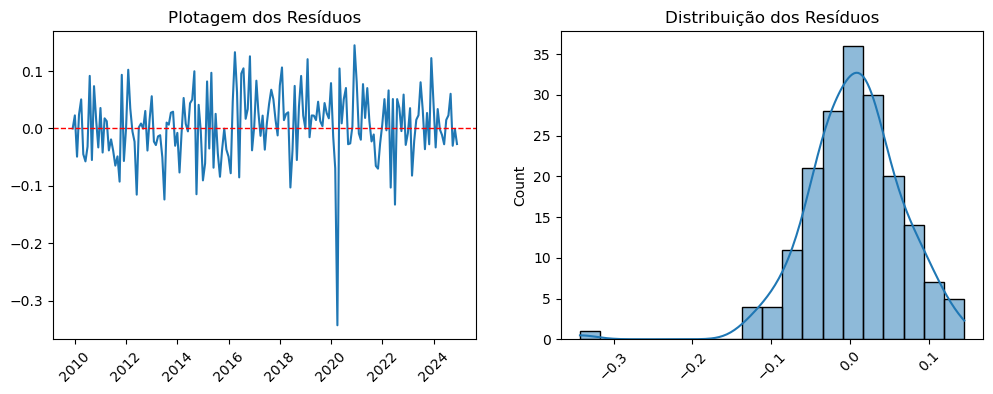

In [175]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(arima_resid, label="Resíduos")
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0].set_title("Plotagem dos Resíduos")
axes[0].tick_params(axis='x', rotation=45)

sns.histplot(arima_resid, kde=True, ax=axes[1])
axes[1].set_title("Distribuição dos Resíduos")
axes[1].tick_params(axis='x', rotation=45)

Text(0.5, 1.0, 'Boxplot dos Resíduos')

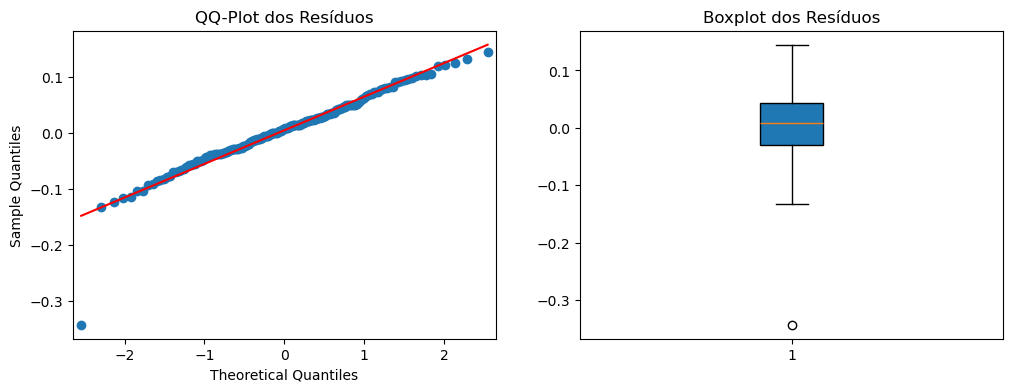

In [176]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sm.qqplot(arima_resid, line="s", ax=axes[0])
axes[0].set_title("QQ-Plot dos Resíduos")

axes[1].boxplot(arima_resid, patch_artist=True)
axes[1].set_title("Boxplot dos Resíduos")

### Teste Shapiro-Wilk

Teste utilizado para avaliar normalidade dos resíduos, a hipótese nula ($H_0$) é de que os dados são normalmente distribuídos. Conforme pode ser vizualizado abaixo, não segue 

In [330]:
sw_stat, p_value = shapiro(arima_resid)

if p_value > 0.05:
    print(f"A estatística do teste é {round(sw_stat,4)} que tem um valor-p de {round(p_value,8)} que é maior que 0.05 e, portanto, segue uma distribuição normal")
else: 
    print(f"A estatística do teste é {round(sw_stat,4)} que tem um valor-p de {round(p_value,8)} que é menor que 0.05 e, portanto, não segue uma distribuição normal")

A estatística do teste é 0.9464 que tem um valor-p de 2.54e-06 que é menor que 0.05 e, portanto, não segue uma distribuição normal


### Teste ARCH

O teste ARCH serve para verificar se os resíduos são heterocedásticos, ou seja, não possuem variância constante ao longo do tempo. Os modelos do tipo ARCH (Autoregressive conditional heteroskedasticity) são modelos desenvolvidos para modelar a heterocedasticidade condicional, se os coeficientes autoregressivos forem estatisticamente significativos, então a variância não é constante. 

Conforme podemos vizualizar, o coeficiente de especial importância é 'alpha[1]' que mostrou-se não estatisticamente significativo o que nos leva assumir que a variância do modelo é constante ao longo do tempo. 

In [312]:
from arch import arch_model

modelo_arch = arch_model(arima_resid*10, vol='ARCH', p=1).fit(disp="off")

modelo_arch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -163.203
Distribution:                  Normal   AIC:                           332.407
Method:            Maximum Likelihood   BIC:                           342.002
                                        No. Observations:                  181
Date:                Sun, Dec 15 2024   Df Residuals:                      180
Time:                        17:36:12   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0813  6.306e-02      1.289      0.197 [-4.232e-02,  0.205]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.2779  8.340e-02      3.332  8.624e-04 [  0.114,  0.441]
alpha[1]       0.2935      0.537      0.546      0.585 [ -0.759,  1.346]
========================================================================

Covariance estimator: robust
"""

## 6. Previsão e Projeção

### Previsão

Abaixo foi feito a previsão do modelo em relação aos dados reais e foi identificado uma alta acurrácia conforme demonstrado pela métrica erro MAPE. 

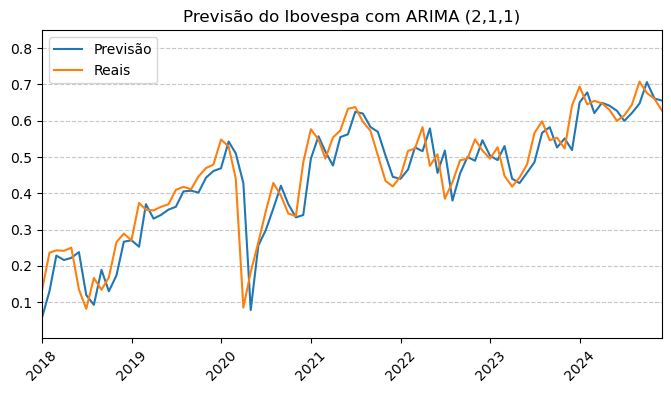

In [355]:
arima_predict = modelo_arima.predict(ibov_data.index[0], ibov_data.index[-1])

plt.figure(figsize=(8,4))

plt.title('Previsão do Ibovespa com ARIMA (2,1,1)')

plt.plot(arima_predict, label = 'Previsão')
plt.plot(ibov_data, label = 'Reais')

plt.xlim(ibov_data.index[-84], ibov_data.index[-1])
plt.ylim(ibov_data.values[-84:-1].min()*0.01, ibov_data.values[-84:-1].max()*1.2)

plt.legend(loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45);

In [272]:
erros_modelo = acuracia(arima_predict[1:], pd.Series(ibov_data["^BVSP"])[1:])
erros_modelo

,Métrica,Descrição,Valor
0,ME,Mean Error,0.005289
1,MAE,Mean Absolute Error,0.045419
2,RMSE,Root Mean Square Error,0.060568
3,MPE,Mean Percentage Error,0.045107
4,MAPE,Mean Absolute Percentage Error,0.557094


In [274]:
print("Acurácia:", round((1-erros_modelo["Valor"].iloc[-1])*100,2), "%")

Acurácia: 44.29 %


### Projeção 

Abaixo projetamos para a série temporal para o futuro com base no modelo que ajustamos.

In [359]:
valor_final = ibov_data.values[-1]

treino_final = pd.DataFrame({'mean': valor_final, 
                             'mean_se': valor_final, 
                             'mean_ci_lower': valor_final, 
                             'mean_ci_upper': valor_final},
                           index = [ibov_data.index[-1]])

arima_forecasts = modelo_arima.get_forecast(3).summary_frame(alpha=0.05)

arima_forecasts_ = pd.concat([treino_final, arima_forecasts])

arima_forecasts_

,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-11-30,0.628294,0.628294,0.628294,0.628294
2024-12-31,0.627071,0.060554,0.508387,0.745756
2025-01-31,0.632735,0.087648,0.460948,0.804522
2025-02-28,0.637052,0.102365,0.436419,0.837684


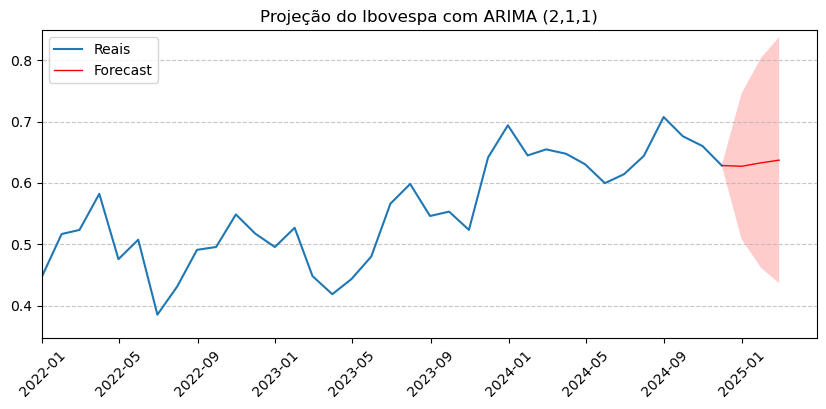

In [361]:
plt.figure(figsize=(10,4))
plt.title('Projeção do Ibovespa com ARIMA (2,1,1)')

plt.plot(ibov_data, label = 'Reais')

plt.plot(arima_forecasts_['mean'], label = 'Forecast', color='red', linewidth=1)

plt.fill_between(arima_forecasts_.iloc[:,2].index,
                 arima_forecasts_.iloc[:,2], 
                 arima_forecasts_.iloc[:,3], 
                 color='red', alpha = 0.2, edgecolor="none")

plt.xlim(ibov_data.index[-36], arima_forecasts_.index[-1] + pd.DateOffset(months=2))
plt.ylim(ibov_data.values[-36:-1].min()*0.9, ibov_data.values[-36:-1].max()*1.2)

plt.xticks(rotation=45)
    
plt.legend(loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Conclusões

Ajustamos um modelo ARIMA para a cotação do Ibovespa em reais (BRL) ao longo dos últimos 20 anos. A série temporal mostrou-se estacionária, conforme indicado pelo teste Dickey-Fuller Aumentado, após a primeira diferença. Com base nos gráficos de autocorrelação, indicava correlação estatisticamente significativa no 2º lag, entretanto o modelo ARIMA (2, 1, 2) gerou parâmetros estatisticamente não significativos o que levou a adotar o processo stepwise que ajudou a escolher um modelo mais parcimonioso que apresentou o menor AIC que foi de -490 e coeficientes estatisticamente significativos para os parâmetros de modelo ARIMA (2,1,1). O modelo encontrado pode ser expresso pela função abaixo: 

$$
y_t = 0.7175 \cdot y_{t-1} -0.2065 \cdot y_{t-2} + \varepsilon_{t} -0.6711 \cdot \varepsilon_{t-1}
$$

O modelo alcançou uma acurácia de 44.29%, ou seja, ele acertou em torno de 44% os verdadeiros valores do Ibovespa . Na análise dos resíduos, constatou-se que não seguia uma distribuição normal pela análise do gráfico QQ-Plot e também pelo gráfico de distribuição dos resíduos, isto se deve a queda expressiva que o índice teve em 2020 no cenário da pandemia do Covid que não conseguiu ser capturado pelo modelo, o teste de Shapiro-Wilk também confirma que os resíduos não seguem uma distribuição normal. Já o teste de Ljung-Box, assim como a análise dos gráficos FAC e FACP indicaram a ausência de autocorrelação nos termos de erro que junto com o teste ARCH foi constatado que os resíduos do modelo não apresentam heterocedasticidade condicional, concluí-se que o modelo capturou de forma adequada a estrutura temporal da série e não há padrões remanescentes nos resíduos. 

# Bibliografia

- Econometria de Séries Temporais
- Python para Séries Temporais
- Os Modelos Arima e a Abordagem de Box-Jenkins: Uma Aplicação na Previsão do IBOVESPA a Curtlssi·mo Prazo (https://periodicos.fgv.br/rae/article/view/38778/37514)